### **Welcome to the TSI-Toolkit!**
The **goal of this tutorial** is to familiarize the user with using tsi-toolkit to import their time series data, to create and compare models that aim to capture the variablity in their data, and apply models to make predictions of the time series at new, previously unobserved data points, either in the future (forecasting) or between observed values (interpolation). 

This package was designed to be convenient and intuitive, regardless of your background in Python and machine learning. I deeply appreciate those who voice their frustrations, whether about bugs or how this package could better serve you. Please feel free to open a new issue post in the [Github Repo's Issue Page](https://github.com/collinlewin/tsi-toolkit/issues), or by emailing me, Collin Lewin (clewin@mit.edu).

##### *In this tutorial, we will learn how to...*
1. Importing, cleaning, and plotting time series data
2. The basics of modeling data with Gaussian processes (GPs)
3. How to train a GP using our data and select between GP models
4. Predicting values of the time series at new times (interpolation or forecasting)
5. Generate a slew of powerful products for gaining insight on the data.

In [90]:
%load_ext autoreload
%autoreload 2

from tsi_toolkit.data_loader import TimeSeries
from tsi_toolkit import preprocessing

import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


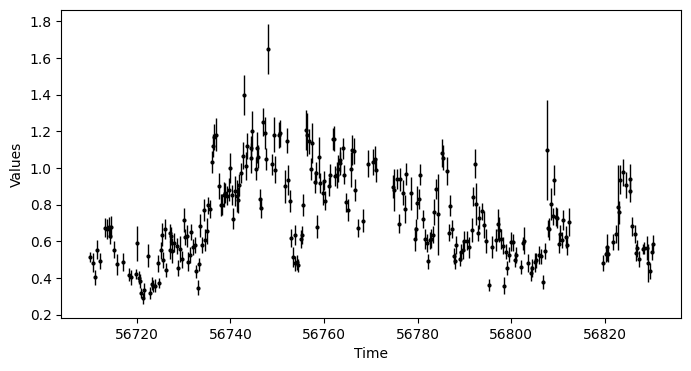

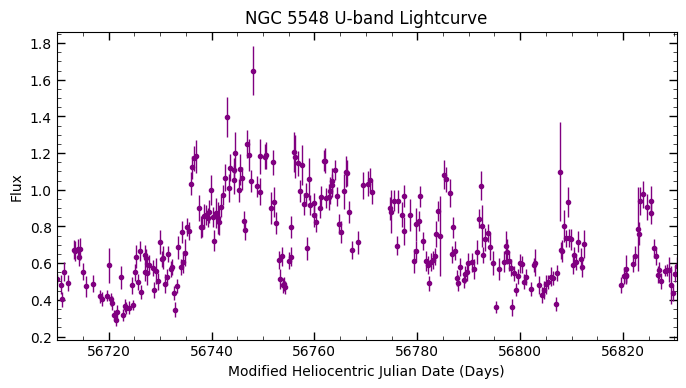

In [91]:
 ### Import data

# Import from file directly
file_path = '/home/clewin/projects/tsi-toolkit/data/'
lightcurve = TimeSeries(file_path = f'{file_path}NGC5548_U_swift.dat')

# Import from array
data = np.genfromtxt(f'{file_path}NGC5548_X_swift.dat')
lightcurve = TimeSeries(times=data[:,0], values=data[:,1], errors=data[:,2])
lightcurve.plot()

# Plot with custom arguments
# the U-band is around 3500 angstroms, and ultraviolet, so let's make the plot violet
lightcurve.plot(figsize=(8,4),
                xlabel='Modified Heliocentric Julian Date (Days)', 
                ylabel='Flux',
                xlim = (lightcurve.times[0], lightcurve.times[-1]),
                title='NGC 5548 U-band Lightcurve',
                fig_kwargs={'linewidth':28},
                plot_kwargs={'color':'purple', 'fmt':'o', 'lw':1, 'ms':3},
                major_tick_kwargs={'direction':'in', 'top':True, 'right':True, 'length':6, 'width':1},
                minor_tick_kwargs={'direction':'in', 'top':True, 'right':True, 'length':3, 'width':0.5},
                )

Removed 0 NaN points.
(0 NaN values, 0 NaN errors)
Removed 11 outliers (4.14% of data).


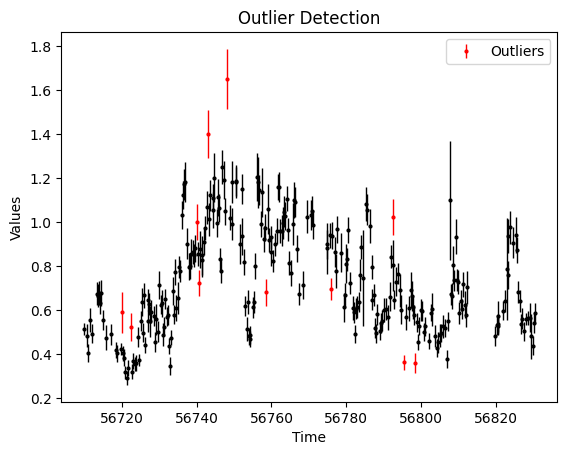

Removed 3 outliers (1.13% of data).


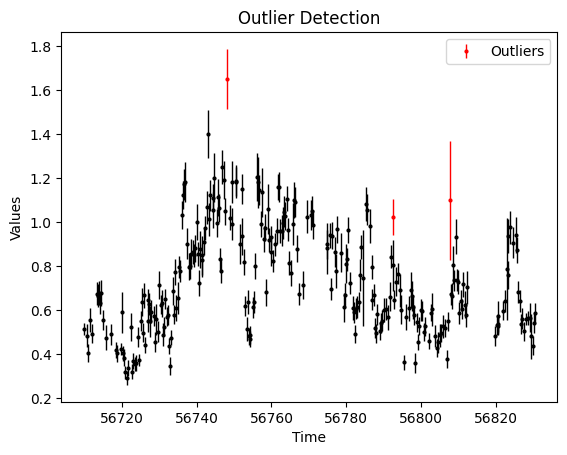

Removed 1 outliers (0.38% of data).


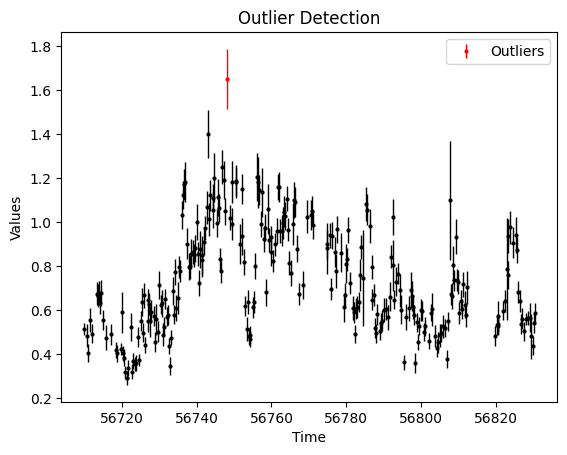

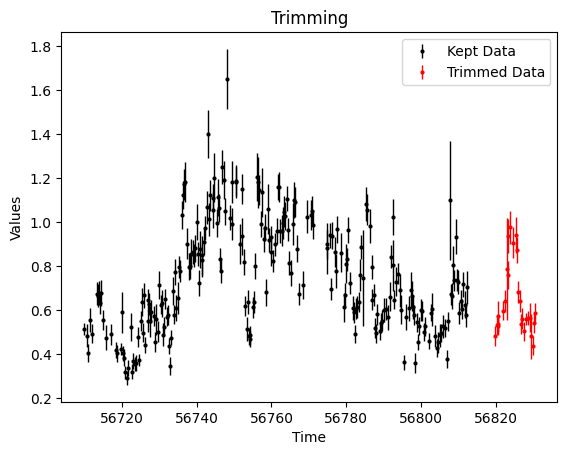

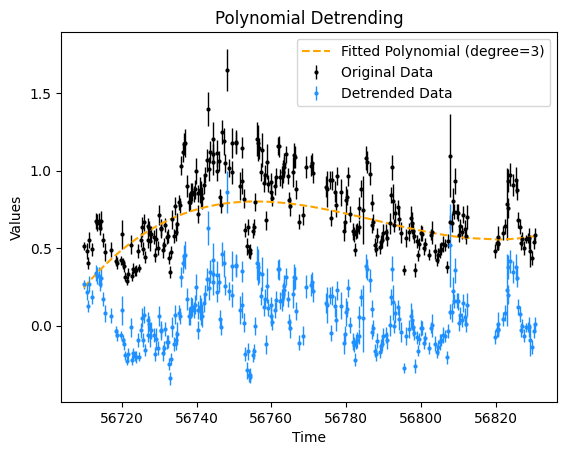

In [92]:
from tsi_toolkit.preprocessing import Preprocessing

# Preprocess the data
Preprocessing.remove_nans(lightcurve)
Preprocessing.remove_outliers(lightcurve, threshold=1.5, rolling_window=10, plot=True, verbose=True, save=False)
Preprocessing.remove_outliers(lightcurve, threshold=1.5, rolling_window=50, plot=True, verbose=True, save=False)
Preprocessing.remove_outliers(lightcurve, threshold=1.5, rolling_window=None, plot=True, verbose=True, save=False)

Preprocessing.trim_time_segment(lightcurve, end_time=56815, plot=True, save=False)
Preprocessing.polynomial_detrend(lightcurve, degree=3, plot=True, save=False)
Preprocessing.standardize(lightcurve)

In [117]:
from tsi_toolkit.gaussian_process import GaussianProcess
gp_model = GaussianProcess(timeseries=lightcurve,
                 kernel_form='auto', white_noise=True, run_training=True, train_iter=10, verbose=True)

print(gp_model.akaike_inf_crit(), gp_model.get_hyperparameters())
gp_model.train_model()

Iter 1/10 - Loss: 1.267   lengthscale: 0.698   noise: 0.688
Iter 2/10 - Loss: 1.264   lengthscale: 0.703   noise: 0.683
Iter 3/10 - Loss: 1.262   lengthscale: 0.708   noise: 0.678
Iter 4/10 - Loss: 1.259   lengthscale: 0.713   noise: 0.673
Iter 5/10 - Loss: 1.256   lengthscale: 0.718   noise: 0.669
Iter 6/10 - Loss: 1.253   lengthscale: 0.724   noise: 0.664
Iter 7/10 - Loss: 1.251   lengthscale: 0.729   noise: 0.659
Iter 8/10 - Loss: 1.248   lengthscale: 0.734   noise: 0.654
Iter 9/10 - Loss: 1.245   lengthscale: 0.739   noise: 0.649
Iter 10/10 - Loss: 1.242   lengthscale: 0.744   noise: 0.644
Training complete. 
   - Final loss (NLML): 1.2423
   - Final hyperparameters:
      likelihood.second_noise_covar.noise       : 0.6445
      covar_module.outputscale                  : 0.6446
      covar_module.base_kernel.lengthscale      : 0.7444
Iter 1/10 - Loss: 1.216   lengthscale: 0.698   noise: 0.640
Iter 2/10 - Loss: 1.213   lengthscale: 0.703   noise: 0.635
Iter 3/10 - Loss: 1.210   len

In [119]:
print(gp_model.akaike_inf_crit())
gp_model.get_hyperparameters()

7.625174253313831


{'likelihood.second_noise_covar.noise': 0.06054611876606941,
 'covar_module.outputscale': 0.6948658227920532,
 'covar_module.base_kernel.lengthscale': 1.2141566276550293}